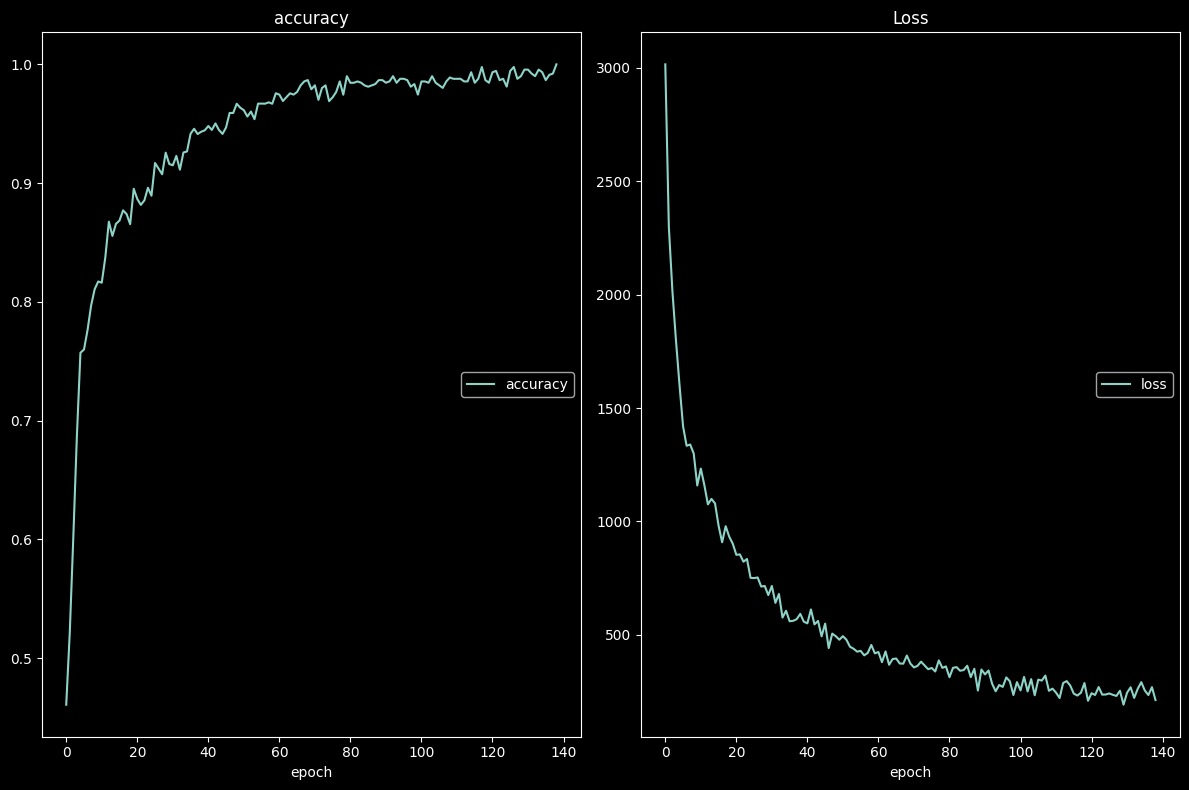

accuracy
	accuracy         	 (min:    0.461, max:    1.000, cur:    1.000)
Loss
	loss             	 (min:  192.594, max: 3014.691, cur:  213.201)


In [6]:
from spacy import prefer_gpu
import torch
from spacy.util import minibatch, compounding
from spacy.training import offsets_to_biluo_tags
import json
import spacy
import pandas as pd
from spacy.training import Example
import random
import re
# from spacy.lang.char_classes import LIST_ELLIPSES, LIST_ICONS, ALPHA, ALPHA_LOWER, ALPHA_UPPER
# from spacy.util import compile_infix_regex
from spacy.tokenizer import Tokenizer
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

# livelossplot 객체를 생성합니다.
liveplot = PlotLosses()
accuracy_list = []
losses_list = []
# liveplot = PlotLosses(groups={'Accuracy vs Loss': ['accuracy', 'loss']})


# 새 모델 생성 또는 기존 모델 로드
nlp = spacy.blank('ko')  # 새 모델을 생성하거나
# nlp.tokenizer = custom_tokenizer(nlp)  # TSV 파일 로드
data = pd.read_csv('/workspace/ko_addr_ner.tsv', sep='\t')


texts = data['text'].tolist()
labels = data['label'].tolist()

# spaCy의 훈련 데이터 형식으로 변환
TRAIN_DATA = []
for text, label in zip(texts, labels):
    entities = []
    for item in json.loads(label):
        start = item['start']
        end = item['end']
        for ent_type in item['labels']:
            entities.append((start, end, ent_type))
    TRAIN_DATA.append((text, {'entities': entities}))
for idx, (text, annotation) in enumerate(TRAIN_DATA):
    doc = nlp.make_doc(text)
    entities = annotation['entities']
    tags = offsets_to_biluo_tags(doc, entities)
    if '-' in tags:
        print(f"Misaligned entities in row {idx}: {text}, {entities}")

# 필요한 열만 선택

# GPU를 사용하도록 설정
if prefer_gpu():
    print("GPU is being used.")
else:
    print("CPU is being used.")


# NER 파이프라인 추가
if 'ner' not in nlp.pipe_names:
    ner = nlp.add_pipe('ner', last=True)
else:
    ner = nlp.get_pipe('ner')

# 새 엔티티 라벨 추가
for _, annotations in TRAIN_DATA:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])


# GPU 사용 가능 여부 확인
if torch.cuda.is_available():
    print("GPU is being used.")
else:
    print("CPU is being used.")


# Set the hyperparameters
dropout = 0.6
compounding_start = 4
compounding_end = 96
compounding_period = 1.001
# n_iter = 10
# 학습 설정
nlp.begin_training()


# 훈련 데이터와 검증 데이터 분리
split = int(len(TRAIN_DATA) * 0.8)
train_data = TRAIN_DATA[:split]
valid_data = TRAIN_DATA[split:]

# 최적 훈련 루프
accuracy = 0.0
threshold = 1.0  # 정확도 임계값 설정
max_accuracy = 0.0
while accuracy < threshold:
    random.shuffle(train_data)
    losses = {}
    # batches = minibatch(train_data, size=compounding(4.0, 128, 1.001))
    batches = minibatch(TRAIN_DATA, size=compounding(compounding_start, compounding_end, compounding_period))
    # batches = minibatch(train_data, size=compounding(4.0, 64.0, 1.001))
    for batch in batches:
        for text, annotations in batch:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], drop=dropout, losses=losses)
    print("Losses", losses)

    # 검증 데이터로 성능 평가
    optimizer = nlp.resume_training()
    with nlp.use_params(optimizer.averages):
        valid_examples = [Example.from_dict(nlp.make_doc(text), annotations) for text, annotations in valid_data]
        scores = nlp.evaluate(valid_examples)
    # print("Scores", scores)
    accuracy = scores['ents_f']  # F1-score를 정확도로 사용
    print(f"accuracy : {accuracy}")

    # 정확도에 따라 모델 저장
    # thresholds = [0.8, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91]
    thresholds = [0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.97, 0.98, 0.99, 0.999, 1.0 ]
    max_threshold = 0

    if accuracy > max_accuracy:
        for threshold in thresholds:
            if max_accuracy < threshold <= accuracy:
                nlp.to_disk(f"/workspace/ko_addr_ner_model_{threshold*1000:.0f}")
                max_threshold = threshold
        max_accuracy = accuracy

    # accuracy와 losses를 리스트에 추가합니다.
    accuracy_list.append(accuracy)
    losses_list.append(losses.get('ner', 0.0))  # 'ner' 키가 없을 경우 0.0을 반환합니다.

    # livelossplot 객체에 accuracy와 losses를 추가하고 차트를 업데이트합니다.
    liveplot.update({
        'accuracy': accuracy,
        'loss': losses.get('ner', 0.0)  # 'ner' 키가 없을 경우 0.0을 반환합니다.
    })
    liveplot.send()
